# Regressão Multilinear — Air Quality (UCI)

Notebook de regressão multilinear com base no dataset Air Quality (UCI). Inclui: descrição do conjunto, EDA, preparação, regressão linear (coeficientes e MAE), redes neurais com MLPRegressor (1 e 2 camadas ocultas), cálculo de correlação, gráficos seaborn (pairplot) e gráfico de 10 amostras de teste y_test vs y_pred.


## Descrição do Dataset
- Nome: Air Quality (UCI)
- Tarefa: Regressão (multivariada, série temporal)
- Instâncias: 9358 (médias horárias de março/2004 a fevereiro/2005)
- Atributos: 15
- Alvos de referência (analisador): CO (GT), NMHC (GT), C6H6 (GT), NOx (GT), NO2 (GT)
- Sensores: PT08.S1 (CO), PT08.S2 (NMHC), PT08.S3 (NOx), PT08.S4 (NO2), PT08.S5 (O3)
- Meteorologia: Temperatura (T), Umidade Relativa (RH), Umidade Absoluta (AH)
- Datas/Tempos: colunas de data e hora
- Valores faltantes codificados: -200
- Observações: há sensibilidades cruzadas e drift de sensores reportados na literatura (De Vito et al., 2008).

> Todas as análises a seguir usam as mesmas variáveis de entrada (sensores + clima) para estimar o alvo contínuo `c6h6_gt` (benzeno). Caso queira avaliar outro gás, basta ajustar `TARGET_COL`, refazendo todo o fluxo.


In [2]:
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

import_or_install('numpy')
import_or_install('pandas')
import_or_install('seaborn')
import_or_install('ucimlrepo')
import_or_install('matplotlib')

In [18]:
try:
    import sklearn
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

sns.set_theme(style='whitegrid', palette='deep', context='notebook')


## Carregamento e Preparação
- Carrega via ucimlrepo (id=360).
- Concatena features e targets.
- Renomeia colunas (snake_case).
- Substitui -200 por NaN nas numéricas.
- Extrai hora/mês/dia-da-semana se `date` e `time` estiverem presentes.


In [7]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
TARGET_ORIGINAL = 'C6H6(GT)'

features_raw = air_quality.data.features
targets_raw = air_quality.data.targets

df = pd.concat([features_raw, targets_raw], axis=1)
orig_cols = df.columns.tolist()

# Renomeia colunas para snake_case e remove caracteres especiais
df.columns = (pd.Series(df.columns)
               .str.strip().str.lower()
               .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
               .str.strip('_'))

# Trata -200 como NaN nas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace(-200, np.nan)

# Extrai atributos de tempo se existir date/time
if {'date', 'time'}.issubset(df.columns):
    dt = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce', dayfirst=True)
    df['hour'] = dt.dt.hour
    df['month'] = dt.dt.month
    df['dayofweek'] = dt.dt.dayofweek

print('Shape (linhas, colunas):', df.shape)

mapping = pd.DataFrame({
    'original': orig_cols,
    'renomeada': df.columns[:len(orig_cols)]
})

display(mapping)
display(df.head())

Shape (linhas, colunas): (9357, 18)


,original,renomeada
0,Date,date
1,Time,time
2,CO(GT),co_gt
3,PT08.S1(CO),pt08_s1_co
4,NMHC(GT),nmhc_gt
5,C6H6(GT),c6h6_gt
6,PT08.S2(NMHC),pt08_s2_nmhc
7,NOx(GT),nox_gt
8,PT08.S3(NOx),pt08_s3_nox
9,NO2(GT),no2_gt


,date,time,co_gt,pt08_s1_co,nmhc_gt,c6h6_gt,pt08_s2_nmhc,nox_gt,pt08_s3_nox,no2_gt,pt08_s4_no2,pt08_s5_o3,t,rh,ah,hour,month,dayofweek
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,10.0,6.0
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19.0,10.0,6.0
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,10.0,6.0
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,10.0,6.0
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,10.0,6.0


## Seleção de Alvo e Atributos
- Alvo padrão: `c6h6_gt` (benzeno).
- Atributos: sensores PT08 + clima (t, rh, ah) e, se presentes, hora/mês/dia-da-semana.
- Remoção de linhas com NaN nas colunas usadas.


In [8]:
TARGET_COL = 'c6h6_gt'

candidate_features = [
    'pt08_s1_co','pt08_s2_nmhc','pt08_s3_nox','pt08_s4_no2','pt08_s5_o3',
    't','rh','ah'
]
for extra in ['hour','month','dayofweek']:
    if extra in df.columns:
        candidate_features.append(extra)

features = [c for c in candidate_features if c in df.columns]
assert TARGET_COL in df.columns, f'Alvo {TARGET_COL!r} não encontrado.'

df_used = df[features + [TARGET_COL]].dropna().copy()
print('Atributos usados:', features)
print('Shape final usado:', df_used.shape)
display(df_used.head())


Atributos usados: ['pt08_s1_co', 'pt08_s2_nmhc', 'pt08_s3_nox', 'pt08_s4_no2', 'pt08_s5_o3', 't', 'rh', 'ah', 'hour', 'month', 'dayofweek']
Shape final usado: (3418, 12)


,pt08_s1_co,pt08_s2_nmhc,pt08_s3_nox,pt08_s4_no2,pt08_s5_o3,t,rh,ah,hour,month,dayofweek,c6h6_gt
0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,10.0,6.0,11.9
1,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,19.0,10.0,6.0,9.4
2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,10.0,6.0,9.0
3,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,10.0,6.0,9.2
4,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,10.0,6.0,6.5


## EDA e Correlações
- Estatísticas descritivas e info.
- Matriz de correlação (heatmap).
- Pairplot para visualização par-a-par.
- Coeficiente de correlação (alvo vs predições será avaliado após o treino).


,count,mean,std,min,25%,50%,75%,max
pt08_s1_co,3418.0,1099.958455,206.365044,689.0000,944.000000,1065.0000,1226.000000,1915.000
pt08_s2_nmhc,3418.0,940.516676,257.636027,387.0000,743.000000,912.5000,1112.000000,1935.000
pt08_s3_nox,3418.0,830.459333,259.476697,328.0000,659.000000,799.0000,956.000000,2683.000
pt08_s4_no2,3418.0,1470.566998,348.642195,551.0000,1239.000000,1494.5000,1689.000000,2746.000
pt08_s5_o3,3418.0,1024.458163,384.557797,221.0000,745.250000,971.0000,1261.500000,2519.000
t,3418.0,18.727940,8.907907,-1.9000,12.400000,18.1000,24.900000,42.600
rh,3418.0,49.996372,17.233994,9.6000,36.400000,51.4000,63.600000,88.700
ah,3418.0,1.074180,0.425436,0.1847,0.758125,1.0464,1.389625,2.231
hour,3418.0,11.483031,6.925827,0.0000,5.000000,11.0000,17.750000,23.000
month,3418.0,6.421592,3.518648,1.0000,3.000000,6.0000,10.000000,12.000


<class 'pandas.core.frame.DataFrame'>
Index: 3418 entries, 0 to 9356
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pt08_s1_co    3418 non-null   float64
 1   pt08_s2_nmhc  3418 non-null   float64
 2   pt08_s3_nox   3418 non-null   float64
 3   pt08_s4_no2   3418 non-null   float64
 4   pt08_s5_o3    3418 non-null   float64
 5   t             3418 non-null   float64
 6   rh            3418 non-null   float64
 7   ah            3418 non-null   float64
 8   hour          3418 non-null   float64
 9   month         3418 non-null   float64
 10  dayofweek     3418 non-null   float64
 11  c6h6_gt       3418 non-null   float64
dtypes: float64(12)
memory usage: 347.1 KB


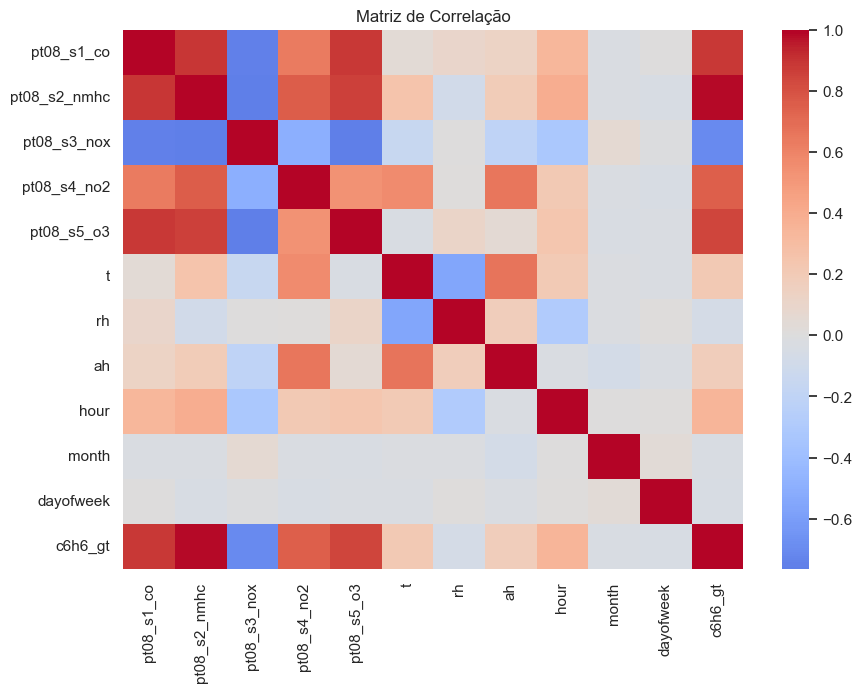

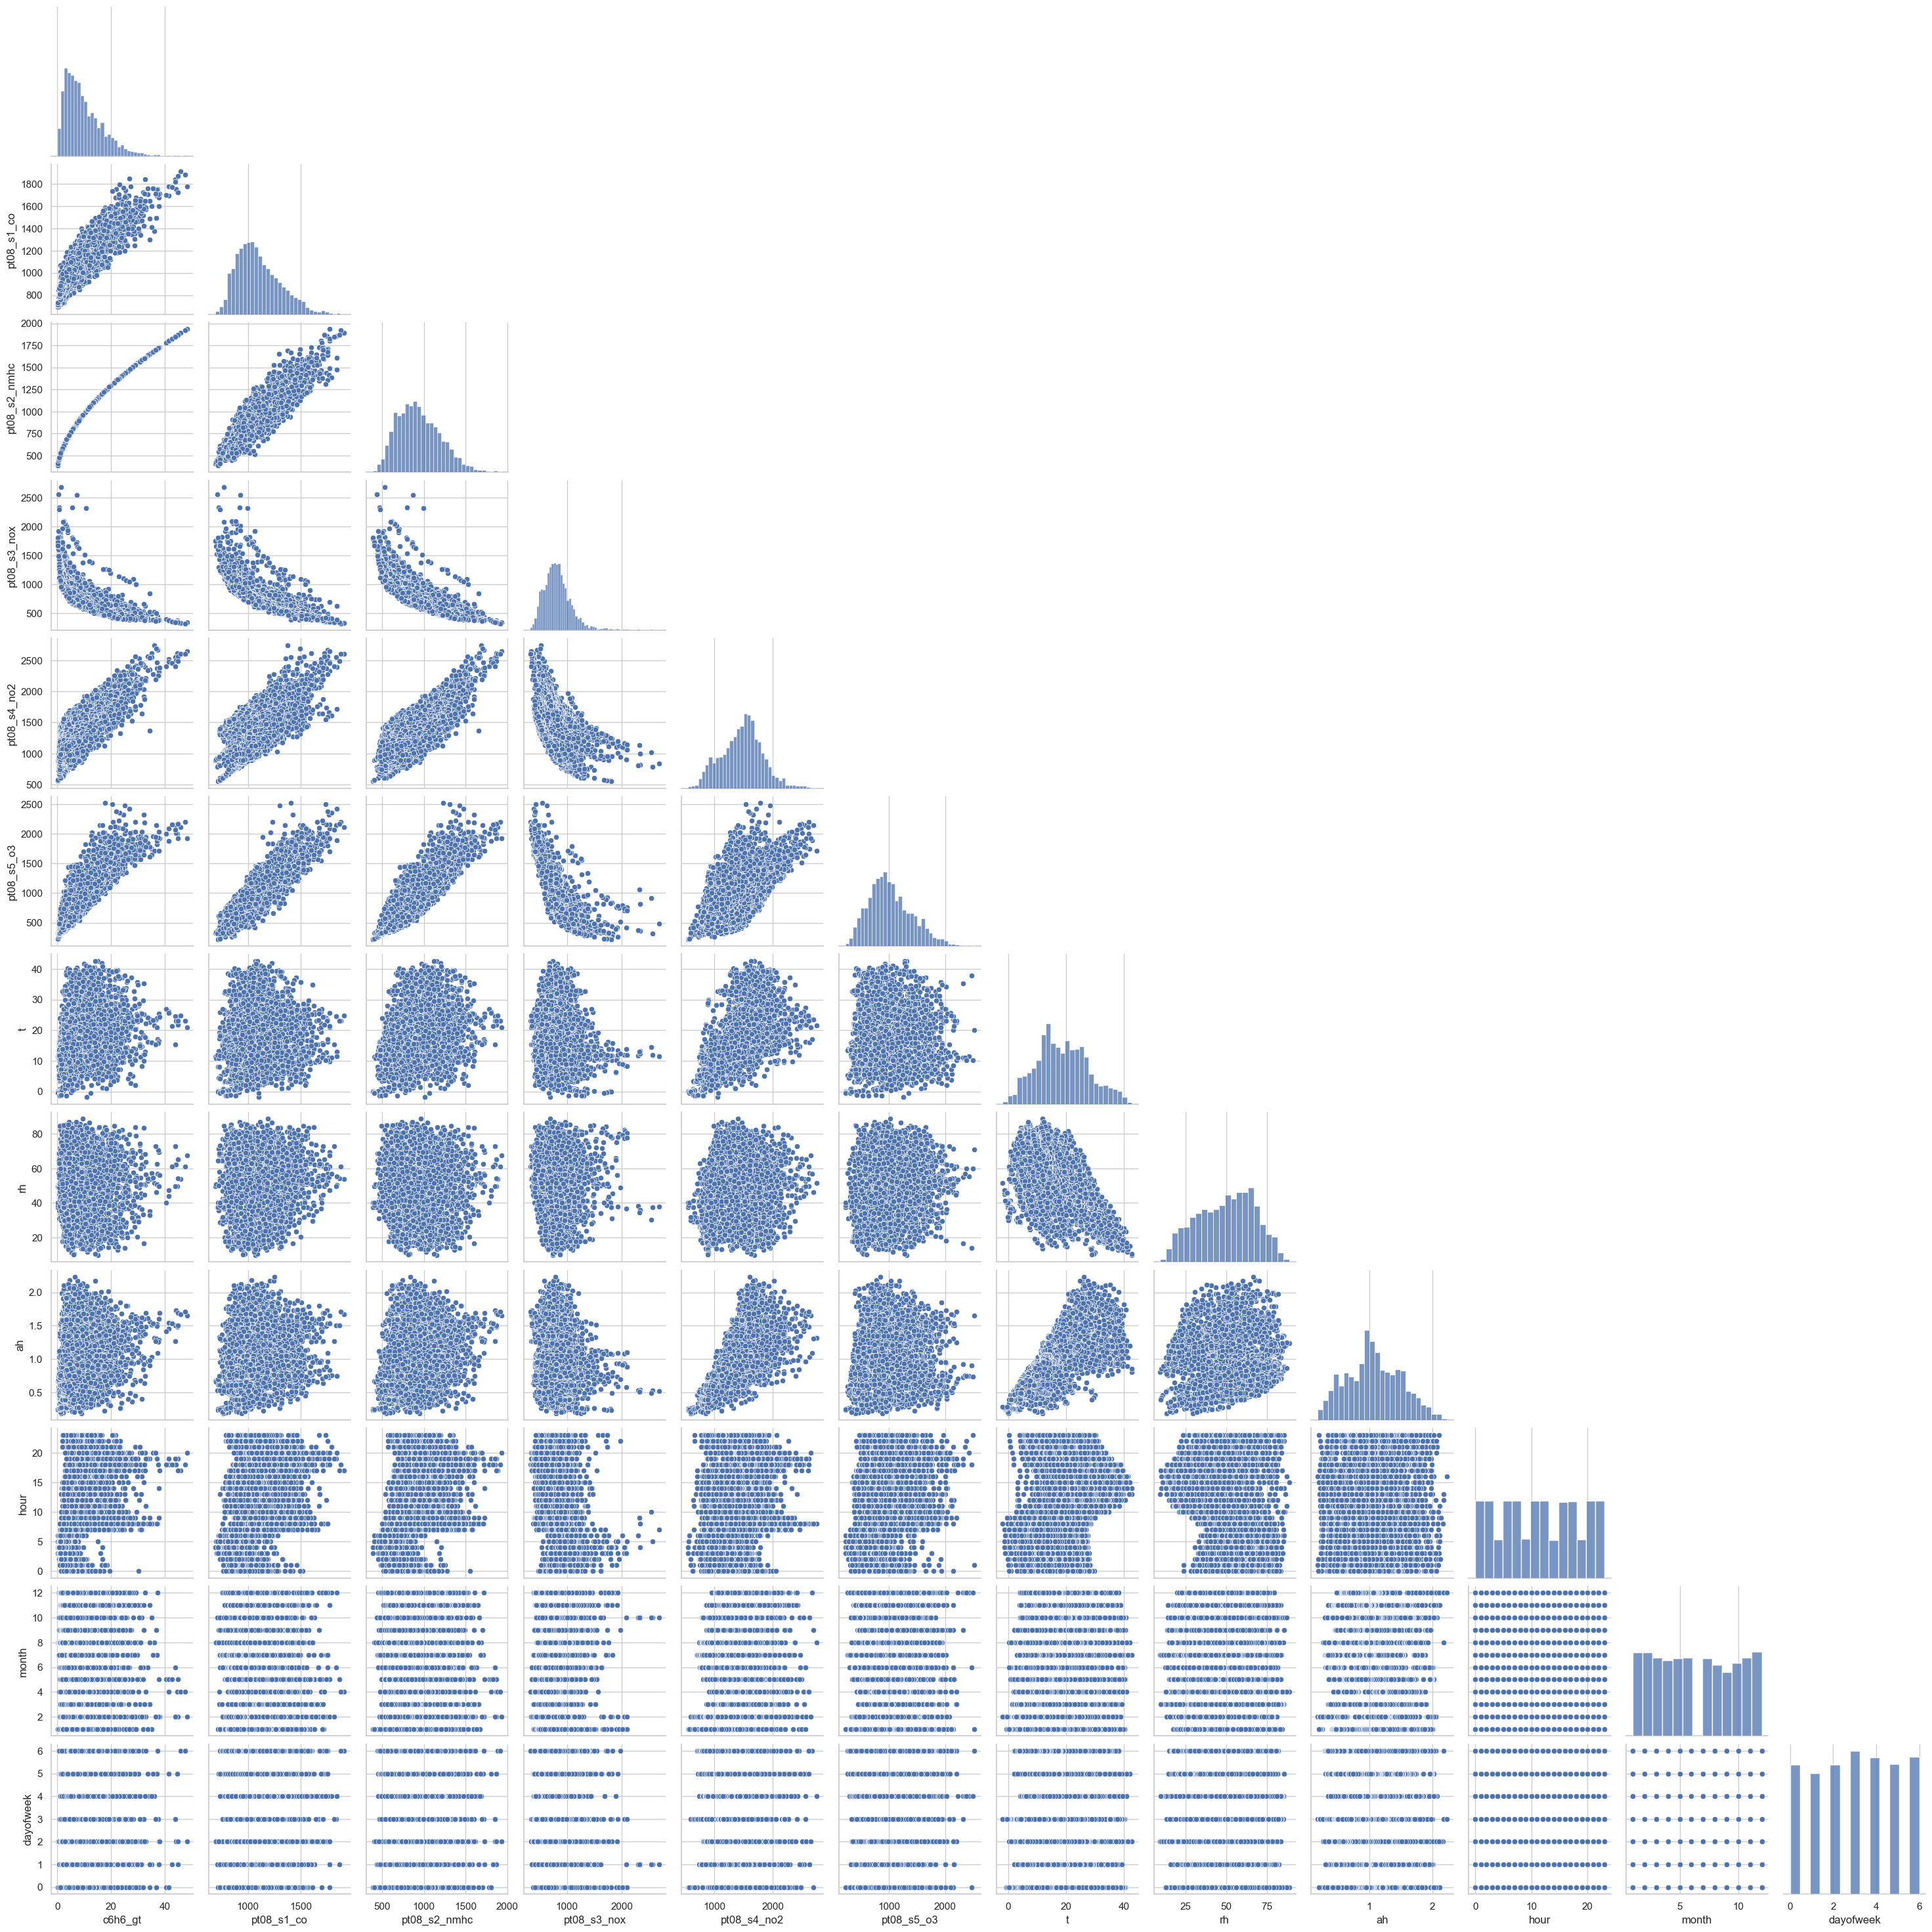

In [9]:
display(df_used.describe().T)
df_used.info()

corr = df_used.corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

sns.pairplot(df_used[[TARGET_COL] + features], corner=True)
plt.show()


### Visualizacoes adicionais

Graficos extras para explorar distribuicoes, sazonalidade e correlacoes.


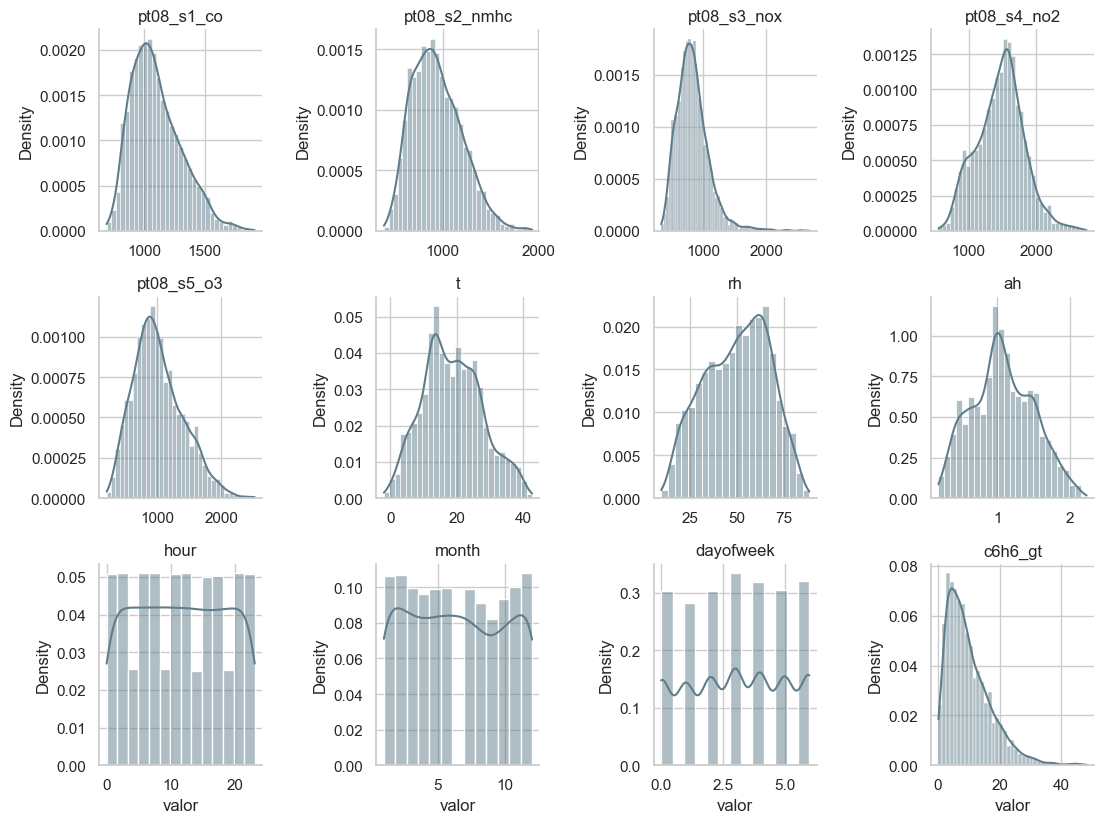

In [10]:
melt_df = df_used.melt(value_vars=features + [TARGET_COL], var_name='variavel', value_name='valor')
g = sns.FacetGrid(melt_df, col='variavel', col_wrap=4, sharex=False, sharey=False, height=2.8)
g.map_dataframe(sns.histplot, x='valor', kde=True, stat='density', color='#607D8B')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()


C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\3682733903.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=TARGET_COL, data=df_used, ax=axes[0], palette='viridis')
C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\3682733903.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dayofweek', y=TARGET_COL, data=df_used, ax=axes[1], palette='viridis')
C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\3682733903.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=TARGET_COL, data=df_used, ax=axes[2], palette='virid

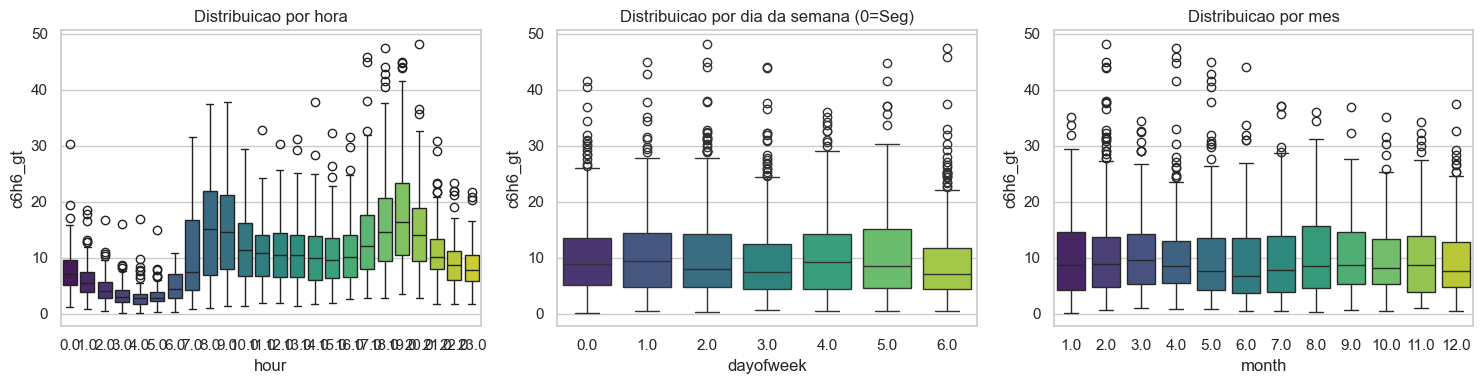

In [11]:
if {'hour', 'month', 'dayofweek'}.issubset(df_used.columns):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.boxplot(x='hour', y=TARGET_COL, data=df_used, ax=axes[0], palette='viridis')
    axes[0].set_title('Distribuicao por hora')
    sns.boxplot(x='dayofweek', y=TARGET_COL, data=df_used, ax=axes[1], palette='viridis')
    axes[1].set_title('Distribuicao por dia da semana (0=Seg)')
    sns.boxplot(x='month', y=TARGET_COL, data=df_used, ax=axes[2], palette='viridis')
    axes[2].set_title('Distribuicao por mes')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas de tempo indisponiveis; boxplots nao gerados.')


C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\2037748939.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm', orient='h')


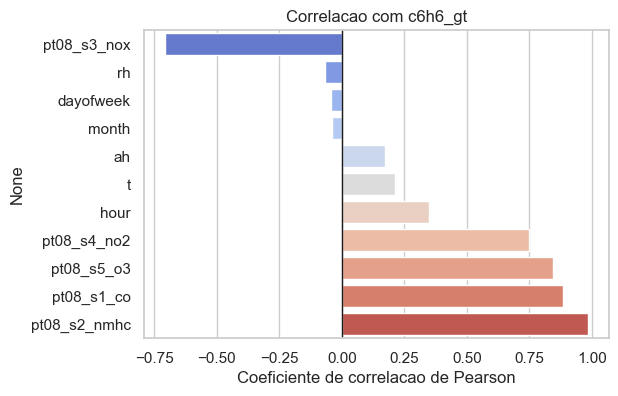

In [12]:
corr_target = corr[TARGET_COL].drop(TARGET_COL).sort_values()
plt.figure(figsize=(6, 4))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm', orient='h')
plt.axvline(0, color='k', lw=1)
plt.title(f'Correlacao com {TARGET_COL}')
plt.xlabel('Coeficiente de correlacao de Pearson')
plt.show()


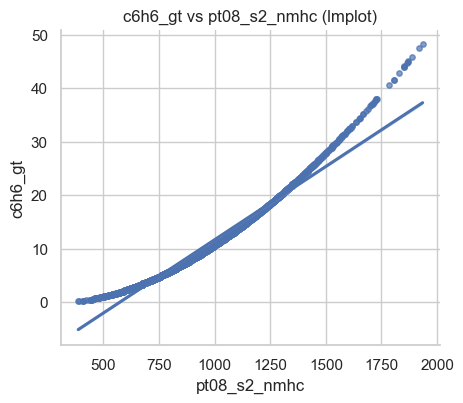

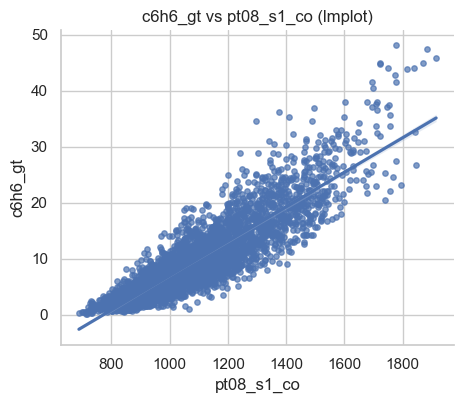

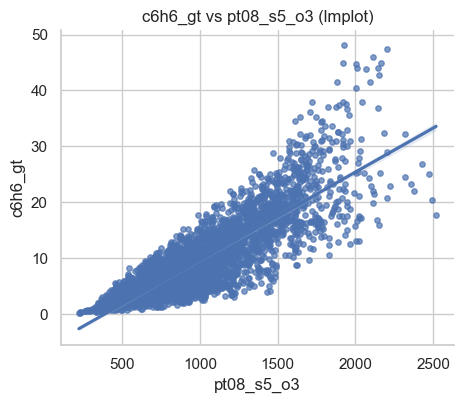

In [13]:
top3 = corr_target.abs().sort_values(ascending=False).head(3).index.tolist()
for feat in top3:
    sns.lmplot(x=feat, y=TARGET_COL, data=df_used, height=4, aspect=1.2, scatter_kws={'s': 15, 'alpha': 0.7})
    plt.title(f'{TARGET_COL} vs {feat} (lmplot)')
    plt.show()


## Split Treino/Teste


In [15]:
X = df_used[features]
y = df_used[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

n_in = X_train.shape[1]
n_out = 1

print('n_in:', n_in, 'n_out:', n_out, 'treino:', X_train.shape, 'teste:', X_test.shape)


n_in: 11 n_out: 1 treino: (2392, 11) teste: (1026, 11)


## Regressão Linear (sklearn)
- Treino com `LinearRegression`.
- Exibir `coef_` e MAE.
- Calcular R², RMSE e correlação Pearson entre y_test e y_pred.


In [19]:
lin = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

lin_model = lin.named_steps['model']
print('Coeficientes (escala padronizada):')
for name, coef in zip(features, lin_model.coef_):
    print(f'{name}: {coef:.6f}')

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
corr_lin = np.corrcoef(y_test, y_pred_lin)[0,1]
print(f'MAE: {mae_lin:.4f} | RMSE: {rmse_lin:.4f} | R2: {r2_lin:.4f} | Corr(y, y_pred): {corr_lin:.4f}')

Coeficientes (escala padronizada):
pt08_s1_co: 0.405831
pt08_s2_nmhc: 7.860501
pt08_s3_nox: 0.771815
pt08_s4_no2: -0.018550
pt08_s5_o3: -0.379169
t: -0.909024
rh: -0.441205
ah: 0.561757
hour: -0.330611
month: -0.056615
dayofweek: 0.031477
MAE: 0.7823 | RMSE: 1.0958 | R2: 0.9761 | Corr(y, y_pred): 0.9880


### Diagnostico regressao linear


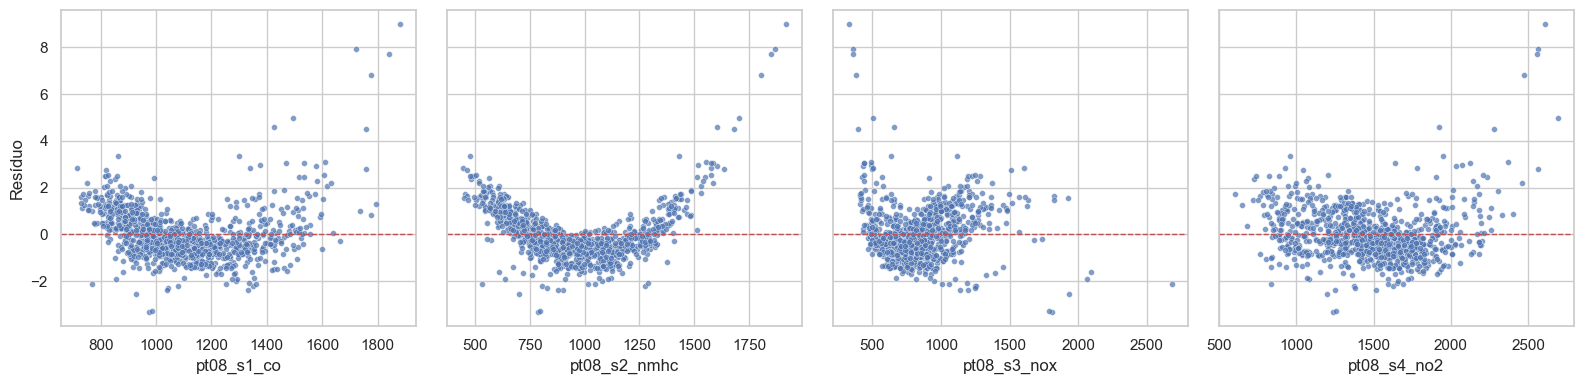

In [20]:
resid_lin = y_test - y_pred_lin
n_feats = min(4, len(features))
fig, axes = plt.subplots(1, n_feats, figsize=(4 * n_feats, 4), sharey=True)
if n_feats == 1:
    axes = [axes]
for ax, feat in zip(axes, features[:n_feats]):
    sns.scatterplot(x=X_test[feat], y=resid_lin, ax=ax, s=18, alpha=0.7)
    ax.axhline(0, color='r', linestyle='--', linewidth=1)
    ax.set_xlabel(feat)
axes[0].set_ylabel('Resíduo')
plt.tight_layout()
plt.show()


C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\849668672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs_df.sort_values('coef_scaled'), x='coef_scaled', y='feature', palette='mako')


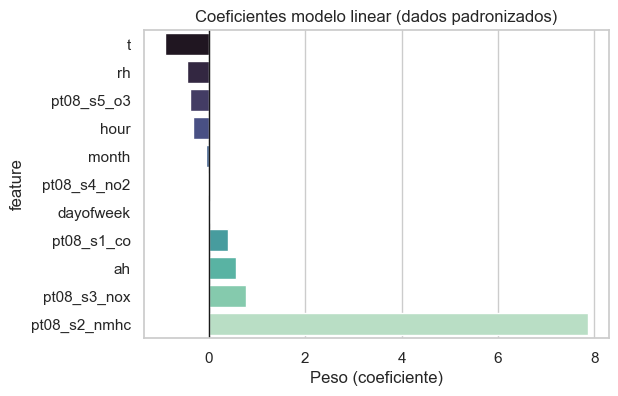

In [21]:
coefs_df = pd.DataFrame({'feature': features, 'coef_scaled': lin_model.coef_})
plt.figure(figsize=(6, 4))
sns.barplot(data=coefs_df.sort_values('coef_scaled'), x='coef_scaled', y='feature', palette='mako')
plt.axvline(0, color='k', lw=1)
plt.title('Coeficientes modelo linear (dados padronizados)')
plt.xlabel('Peso (coeficiente)')
plt.show()


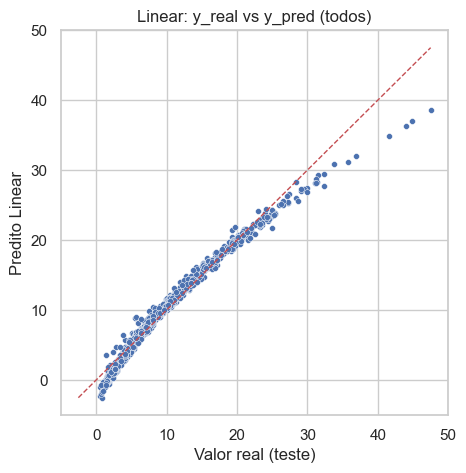

In [22]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred_lin, s=18)
lims = [min(y_test.min(), y_pred_lin.min()), max(y_test.max(), y_pred_lin.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel('Valor real (teste)')
plt.ylabel('Predito Linear')
plt.title('Linear: y_real vs y_pred (todos)')
plt.show()


## Rede Neural — MLPRegressor
- Configuração A: 1 camada oculta com nº de neurônios = média entre nº de entradas e saídas.
- Configuração B: 2 camadas ocultas, segunda com metade da primeira.
- Avaliar MAE, RMSE, R² e Corr(y, y_pred).


In [24]:
hidden1 = int(round((n_in + n_out)/2))
hidden2 = max(1, hidden1//2)
print('Arquiteturas MLP -> A:', (hidden1,), ' | B:', (hidden1, hidden2))

mlp_a = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(hidden_layer_sizes=(hidden1,), random_state=42, max_iter=2000))
])
mlp_b = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(hidden_layer_sizes=(hidden1, hidden2), random_state=42, max_iter=3000))
])

mlp_a.fit(X_train, y_train)
mlp_b.fit(X_train, y_train)

y_pred_a = mlp_a.predict(X_test)
y_pred_b = mlp_b.predict(X_test)

def report(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    print(f'{name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f} | Corr: {corr:.4f}')

report(y_test, y_pred_a, 'MLP A (1 camada)')
report(y_test, y_pred_b, 'MLP B (2 camadas)')

Arquiteturas MLP -> A: (6,)  | B: (6, 3)
MLP A (1 camada) -> MAE: 0.3860 | RMSE: 0.5487 | R2: 0.9940 | Corr: 0.9970
MLP B (2 camadas) -> MAE: 0.1273 | RMSE: 0.1863 | R2: 0.9993 | Corr: 0.9997


### Comparacao de modelos


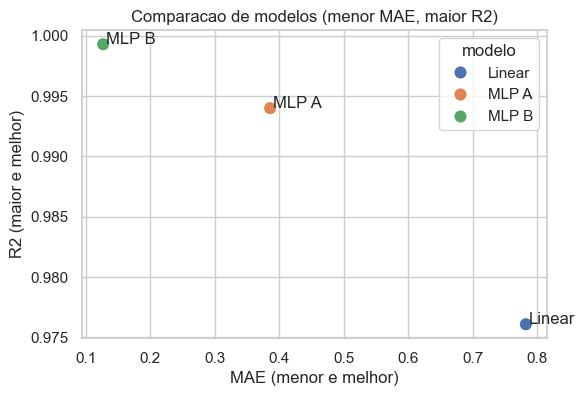

In [25]:
results_plot = pd.DataFrame({
    'modelo': ['Linear', 'MLP A', 'MLP B'],
    'r2': [r2_score(y_test, y_pred_lin), r2_score(y_test, y_pred_a), r2_score(y_test, y_pred_b)],
    'mae': [
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_a),
        mean_absolute_error(y_test, y_pred_b)
    ]
})
plt.figure(figsize=(6, 4))
sns.scatterplot(data=results_plot, x='mae', y='r2', hue='modelo', s=90)
for _, row in results_plot.iterrows():
    plt.text(row['mae'] + 0.005, row['r2'], row['modelo'])
plt.title('Comparacao de modelos (menor MAE, maior R2)')
plt.xlabel('MAE (menor e melhor)')
plt.ylabel('R2 (maior e melhor)')
plt.show()


## y_test vs. y_pred — 10 Amostras Aleatórias
Selecione 10 amostras aleatórias do conjunto de teste e plote y_real vs. y_pred para o melhor modelo (maior R²).


Melhor modelo para o gráfico (R²): MLP_B 0.9993084182253476


,y_real,y_pred
0,9.6,9.688746
1,6.1,6.182249
2,23.0,23.112970
3,9.8,9.896758
4,8.4,8.448904
5,4.8,4.805049
6,4.2,4.131295
7,19.7,19.547540
8,1.8,2.091956
9,2.9,2.918606


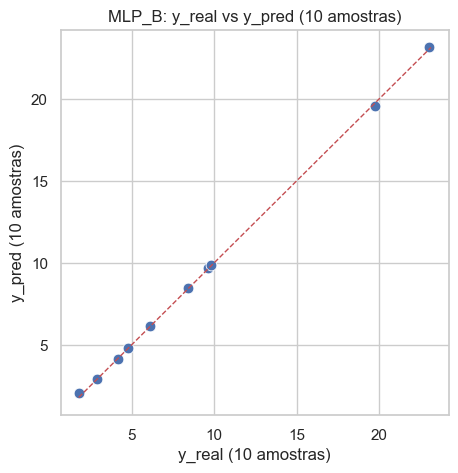

In [26]:
# Escolhe o melhor modelo com base no R²
scores = {
    'Linear': r2_score(y_test, y_pred_lin),
    'MLP_A': r2_score(y_test, y_pred_a),
    'MLP_B': r2_score(y_test, y_pred_b)
}
best_name = max(scores, key=scores.get)
pred_map = {'Linear': y_pred_lin, 'MLP_A': y_pred_a, 'MLP_B': y_pred_b}
y_pred_best = pred_map[best_name]
print('Melhor modelo para o gráfico (R²):', best_name, scores[best_name])

rng = np.random.default_rng(42)
idx = rng.choice(len(y_test), size=10, replace=False)

sample_df = pd.DataFrame({
    'y_real': y_test.iloc[idx].to_numpy(),
    'y_pred': y_pred_best[idx]
})

display(sample_df)

plt.figure(figsize=(5, 5))
sns.scatterplot(x='y_real', y='y_pred', data=sample_df, s=60)
lims = [min(sample_df['y_real'].min(), sample_df['y_pred'].min()),
        max(sample_df['y_real'].max(), sample_df['y_pred'].max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel('y_real (10 amostras)')
plt.ylabel('y_pred (10 amostras)')
plt.title(f'{best_name}: y_real vs y_pred (10 amostras)')
plt.show()
